In [1]:
import warnings

warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


# 数据读取+时间数据处理+归一化

In [2]:
# 读取数据
train = pd.read_csv(r".\\Data\\train_data.csv")
test = pd.read_csv(r".\\Data\\test_data.csv")

# 标准化数据
scaler = MinMaxScaler(feature_range=(0, 1))
features = ["temp", "atemp", "hum", "windspeed", "season", "weekday", "hr", "holiday", "weathersit", "workingday","cnt"]
train = train[features]
test = test[features]
train.dropna(inplace=True)
features = features[:-1]
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

cnt_scaler = MinMaxScaler()
train["cnt"] = cnt_scaler.fit_transform(train[["cnt"]])
test["cnt"] = cnt_scaler.transform(test[["cnt"]])

# 数据准备 时间步=96

In [3]:
# 准备数据
def prepare_data(X, y, past_steps=96, forecast_steps=240):
    Xs, Ys = [], []
    for i in tqdm(range(len(X) - past_steps - forecast_steps + 1)):
        # 输入包含过去 96 小时的数据
        Xs.append(X.iloc[i:i + past_steps].to_numpy())
        # 输出为未来 240 小时的目标值
        Ys.append(y.iloc[i + past_steps:i + past_steps + forecast_steps].to_numpy())
    return np.array(Xs), np.array(Ys)


past_steps = 96    # 利用过去 
forecast_steps = 240  # 预测未来 

X_train, y_train = prepare_data(train, train.cnt, past_steps=past_steps, forecast_steps=forecast_steps)
X_test, y_test = prepare_data(test, test.cnt, past_steps=past_steps, forecast_steps=forecast_steps)

# 转换为 PyTorch 张量
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



print("X_train : {}\nX_test : {}\ny_train : {}\ny_test: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))


100%|██████████| 1825/1825 [00:00<00:00, 18474.43it/s]


X_train : torch.Size([14881, 96, 11])
X_test : torch.Size([1825, 96, 11])
y_train : torch.Size([14881, 240])
y_test: torch.Size([1825, 240])


# 模型构建

In [4]:
    
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # 输出维度为预测时间步数

    def forward(self, x):
        out, _ = self.lstm(x)  # LSTM 输出所有时间步的特征
        out = self.dropout(out[:, -1, :])  # 只取最后一个时间步的特征
        out = self.fc(out)  # 线性层生成未来 240 小时的预测
        return out


input_dim = X_train.shape[2]
hidden_dim = 128
output_dim = forecast_steps  # 预测未来 240 小时
num_layers = 1
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)

# 训练

In [5]:
# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 100
batch_size = 32
train_loss_history = []
val_loss_history = []


for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # 验证集损失
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss / len(X_train):.4f}, Val Loss: {val_loss.item():.4f}")


Epoch 1/100, Train Loss: 0.0005, Val Loss: 0.0372
Epoch 2/100, Train Loss: 0.0005, Val Loss: 0.0421
Epoch 3/100, Train Loss: 0.0004, Val Loss: 0.0416
Epoch 4/100, Train Loss: 0.0004, Val Loss: 0.0401
Epoch 5/100, Train Loss: 0.0004, Val Loss: 0.0347
Epoch 6/100, Train Loss: 0.0004, Val Loss: 0.0340
Epoch 7/100, Train Loss: 0.0004, Val Loss: 0.0331
Epoch 8/100, Train Loss: 0.0004, Val Loss: 0.0330
Epoch 9/100, Train Loss: 0.0004, Val Loss: 0.0325
Epoch 10/100, Train Loss: 0.0004, Val Loss: 0.0316
Epoch 11/100, Train Loss: 0.0003, Val Loss: 0.0303
Epoch 12/100, Train Loss: 0.0003, Val Loss: 0.0303
Epoch 13/100, Train Loss: 0.0003, Val Loss: 0.0292
Epoch 14/100, Train Loss: 0.0003, Val Loss: 0.0292
Epoch 15/100, Train Loss: 0.0003, Val Loss: 0.0284
Epoch 16/100, Train Loss: 0.0003, Val Loss: 0.0288
Epoch 17/100, Train Loss: 0.0003, Val Loss: 0.0272
Epoch 18/100, Train Loss: 0.0003, Val Loss: 0.0275
Epoch 19/100, Train Loss: 0.0003, Val Loss: 0.0274
Epoch 20/100, Train Loss: 0.0003, Val Lo

# 训练曲线

In [6]:
# 保存模型
# 保存整个模型
torch.save(model, "LSTM240-5.pth")

# 或仅保存模型的参数
torch.save(model.state_dict(), "LSTM240_state-5.pth")

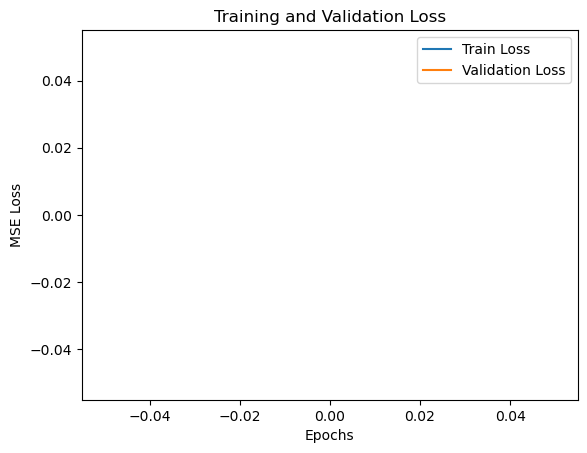

In [7]:
# 绘制损失曲线
plt.plot(train_loss_history, label="Train Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.show()

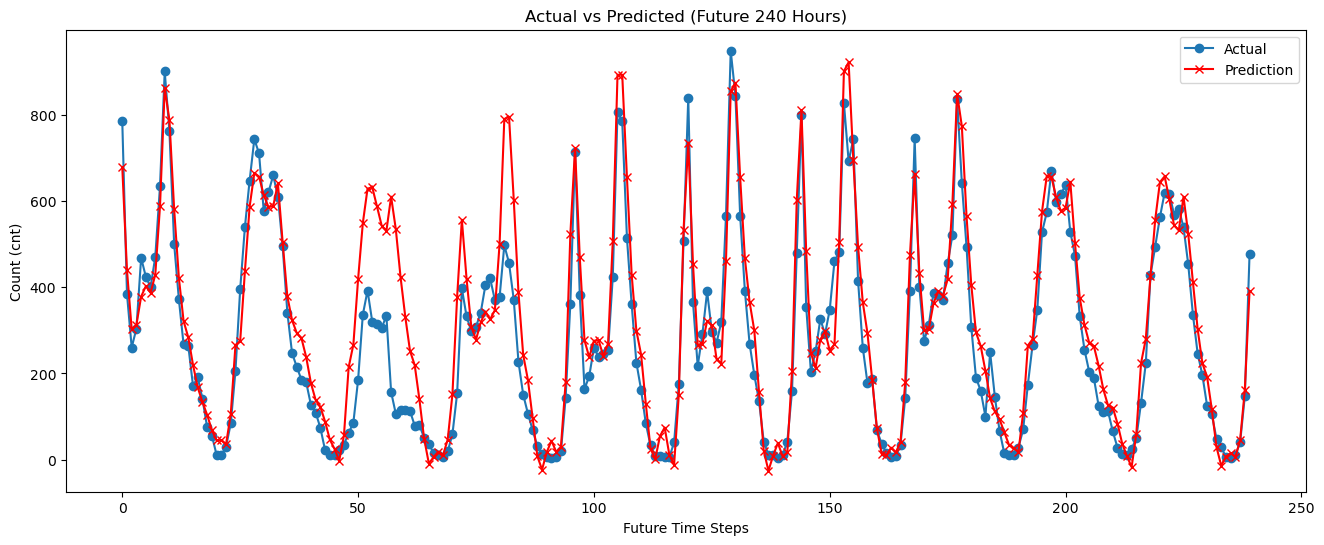

In [8]:
# 切换模型到评估模式
model.eval()

# 禁用梯度计算
with torch.no_grad():
    # 使用模型进行预测
    y_pred = model(X_test).cpu().numpy()  # 预测值转为 NumPy 数组
    y_true = y_test.cpu().numpy()  # 真实值转为 NumPy 数组

# 将预测值和真实值反标准化
y_test_inv = cnt_scaler.inverse_transform(y_test.cpu().numpy().reshape(-1, forecast_steps))
y_pred_inv = cnt_scaler.inverse_transform(val_outputs.cpu().numpy().reshape(-1, forecast_steps))


sample_idx = 0  # 选择一个样本进行可视化
plt.figure(figsize=(16, 6))
plt.plot(range(forecast_steps), y_test_inv[sample_idx], marker="o", label="Actual")
plt.plot(range(forecast_steps), y_pred_inv[sample_idx], marker="x", label="Prediction", color="r")
plt.legend()
plt.title("Actual vs Predicted (Future 240 Hours)")
plt.xlabel("Future Time Steps")
plt.ylabel("Count (cnt)")
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
r2 = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())

print(f"Overall RMSE: {rmse:.4f}")
print(f"Overall R²: {r2:.4f}")


Overall RMSE: 143.4927
Overall R²: 0.4782
